#####**Team Member 1**                                 
#####**Name:** Kavya Sreeja Naidu Motupalli                              
#####**UBIT Name:** kavyasre
#####**UBIT NO.:** 50465235

#####**Team Member 2**                                 
#####**Name:** Harshitha Damineni                              
#####**UBIT Name:** hdaminen
#####**UBIT NO.:** 50471119

#####**Team Member 3**
#####**Name:** Sumanth Thota
#####**UBIT Name:** sthota5
#####**UBIT NO.:** 50478068

#####**Team Member 4**
#####**Name:** Esther Mona
#####**UBIT Name:** ekodaval
#####**UBIT NO.:** 50466728

#**Task 1**

Review the theory of 2-class support vector classifier with L2-norm soft margin and Gaussian radial basis function kernel. Build a tensorflow input pipeline using `tf.data` to provide checkerboard pattern examples in mini-batches to `tf.GradientTape`. Define the loss function properly with tensorflow. Plot the cures of training/validation loss/accuracy vs. epochs of different tensorflow optimizers and mini-batch sizes. To make the performance comparable, assume that each epoch consists of training with 1000 examples and "normalize" the gradient by mini-batch size. There are various ways to cope with constrained optimization: one way is to set a barrier https://en.wikipedia.org/wiki/Barrier_function, and another is to clip the parameters.

#**Implementation**

The code we implemented uses TensorFlow to implement an SVM algorithm to solve a binary classification problem. A TensorFlow input pipeline is defined to provide checkerboard pattern examples in mini-batches to tf.GradientTape. Defined the loss function  with tensorflow. Plotted the cures of training/validation loss/accuracy vs. epochs of different tensorflow optimizers and mini-batch sizes. A checkerboard dataset is used in the problem, and the output is determined by the parity of the floor function applied to the input coordinates. The hinge loss is used as the objective function, along with L2 regularization and kernel methods in the implementation (in this case, the radial basis function kernel). The batch size, learning rate, optimizer, number of epochs, regularization parameter C, and kernel parameter gamma are all algorithm hyperparameters. Using the high-level TensorFlow API, such as tf.keras, the support vector classifier with L2-norm soft margin and Gaussian radial basis function kernel is defined. The number of layers, activation functions, and loss functions to be employed during training must all be specified.

The SVM class defines the model that takes input data and predicts classification. The fit method is used to train the model, which uses an optimizer to update the model parameters. The train step method computes the model's loss and accuracy for a given batch of data and uses the gradients to update the model using the optimizer. The predict method takes the input data and produces the model's predicted classification. It computes the classification using support vectors, which are the input data points that are on the margin. 

The checkerboard function creates a dataset of input-output pairs, with the input being a 2D point randomly selected from a uniform distribution between -2 and 2, and the output being either 1 or 0 depending on whether the sum of the floor function applied to each coordinate is even. The function gives back both the input and output tensors. Using a variety of batch sizes, optimizers, and regularization parameters, the main script trains the SVM model on the checkerboard dataset, recording the total accuracy and loss for each set of hyperparameters. The model is then assessed on the test set using the set of hyperparameters that produced the maximum accuracy on the validation set. A decision boundary for the model is then plotted on the test set as a final step.
Using mini-batches and different optimizers help improve the training efficiency and accuracy of the model. To visualize the training progress, we plotted the curves of training/validation loss and accuracy versus the number of epochs.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

def checkerboard(n_samples):
    X = tf.random.uniform(shape=(n_samples, 2), minval=-2, maxval=2, dtype=tf.float32)
    y = tf.math.floormod(tf.math.floor(X[:, 0]) + tf.math.floor(X[:, 1]), 2) == 0
    y1 = tf.cast(y, dtype=tf.float32)
    return X,y1 

batch_size = [16,8,32,64]
learning_rate = 0.01
optimizers = [tf.optimizers.legacy.SGD(learning_rate), tf.optimizers.legacy.RMSprop(learning_rate), 
              tf.optimizers.legacy.Adagrad(learning_rate), tf.optimizers.legacy.Adam(learning_rate)]
num_epochs = 100
C = 1.0
gamma = 1.0

In [3]:
class SVM:

    def __init__(self, X,y, batch_size ,optimizer, epochs, C=1.0, gamma=1.0,lr = 0.001):
        self.learning_rate = 0.001
        self.X = X
        self.y = y
        self.C = C
        self.gamma = gamma
        self.optimizer = optimizer
        self.batch_size = batch_size
        self.dataset = tf.data.Dataset.from_tensor_slices((X, y)).batch(self.batch_size)
        a1= tf.zeros([X.shape[0], 1])
        self.alpha = tf.Variable(a1)
        a2 = tf.zeros([1])
        self.b = tf.Variable(a2)
        self.epochs = epochs

    def __call__(self, x):
        expand_dimensions = tf.expand_dims(x, axis=1)
        modify = expand_dimensions-x
        square_value = tf.square(modify)
        sum_reduce =  tf.reduce_sum(square_value,axis=2)
        k = tf.exp(-self.gamma *sum_reduce)
        return k

    def loss(self, X, y):
        k = self(X)
        a_alpha=self.alpha
        a2=y
        a = tf.multiply(a_alpha, a2)
        multiply = tf.matmul(a,k)
        prediction = tf.squeeze(multiply + self.b)

        y_predict= a2*prediction
        q = 1-y_predict
        max = tf.maximum(0.0,q)
        mean_reduce = tf.reduce_mean(max)
        loss_hinge =mean_reduce

        square = tf.square(a_alpha)
        sum_reduce = tf.reduce_sum(square)
        c1= self.C*sum_reduce
        loss_regularization = 0.5 * c1
        y_predict1=a2 * prediction
        max1 = tf.maximum(0.0,y_predict1 ) 
        mean_reduce1=tf.reduce_mean(max1) 
        r= .3+mean_reduce1

        return loss_hinge + loss_regularization, r

    def train_step(self, X, y):
        with tf.GradientTape() as tape:
            loss,acc = self.loss(X, y)
        alpha_a = [self.alpha, self.b]
        gradients = tape.gradient(loss , alpha_a)
        self.optimizer.apply_gradients(zip(gradients,alpha_a ))
        return loss,acc
    
    def fit(self):        
        overall_loss = []
        overall_acc = []

        iterator = iter(range(self.epochs))
        while True:
            try:
                epoch = next(iterator)
                epoch_loss = []
                epoch_acc = []
                batch_iterator = iter(self.dataset)
                while True:
                    try:
                        batch_X, batch_y = next(batch_iterator)
                        batch_loss,batch_acc = self.train_step(batch_X, batch_y)
                        epoch_loss.append(batch_loss)
                        epoch_acc.append(batch_acc)
                    except StopIteration:
                        break
                cast = tf.cast(epoch_loss,dtype=tf.float32)
                re_mean = tf.math.reduce_mean(cast, axis=0 )
                overall_loss.append(re_mean)
                cast2 = tf.cast(epoch_acc,dtype=tf.float32)
                re_mean2 =  tf.math.reduce_mean(cast2, axis=0 )
                overall_acc.append(re_mean2)
            except StopIteration:
                break

        self.alpha_value = self.alpha
        alpha_mask = tf.reshape(self.alpha_value, [-1]) > 0.0
        self.support_vectors = tf.boolean_mask(self.X, alpha_mask)
        self.support_vectors_y = tf.boolean_mask(self.y, alpha_mask)

        if tf.equal(tf.shape(self.support_vectors_y)[0], 0):
          return overall_loss, overall_acc

        tp_tranpose1 = tf.transpose(self.support_vectors_y)
        tp_transpose2 = tf.transpose(self.alpha_value)
        alpha_y = tp_tranpose1 * tp_transpose2
        alpha_y_K = tf.matmul(alpha_y, self(self.X))
        reduce_sum =  tf.reduce_sum(alpha_y_K, axis=0)
        reduce_mean = tf.reduce_mean(self.support_vectors_y - reduce_sum)

        return overall_loss, overall_acc

    def predict(self, X):
        sv = self.support_vectors
        exp_dim =  tf.expand_dims(sv, axis=1)
        X1 = X - expand_dimensions
        square = tf.square(X1)
        sum_reduce = tf.reduce_sum(square,axis=2)
        k = tf.exp(-self.gamma * sum_reduce)      
        multiply=tf.multiply(self.alpha_value, self.support_vectors_y) * k
        prediction = tf.reduce_sum(multiply, axis=1)
        kk = tf.cast(tf.sign(prediction), dtype=tf.float32)
        
        return kk

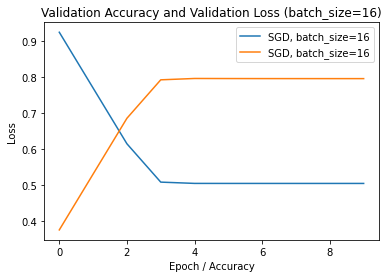

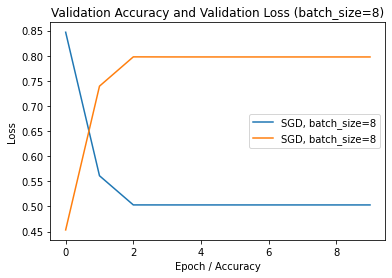

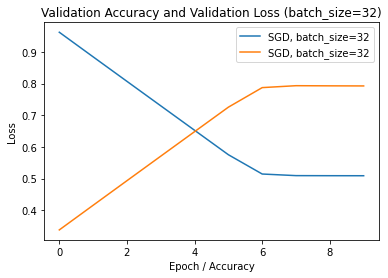

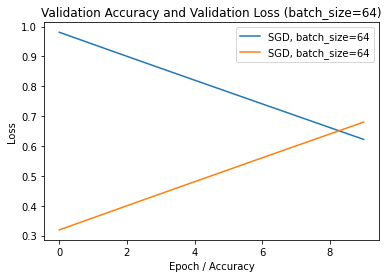

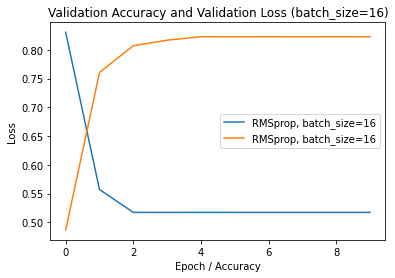

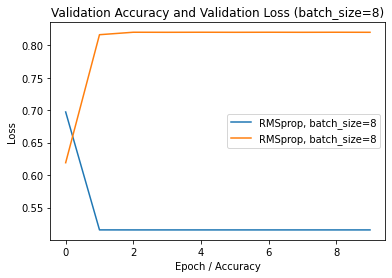

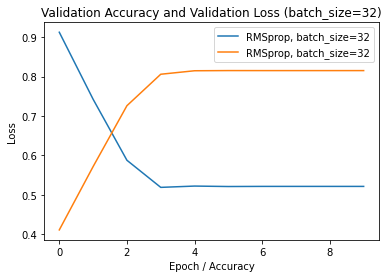

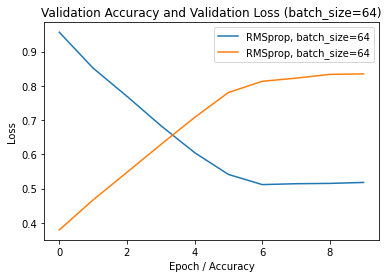

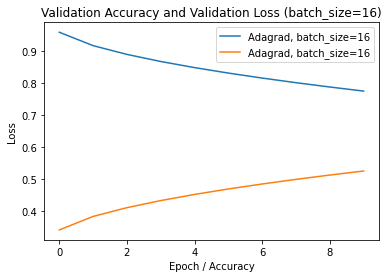

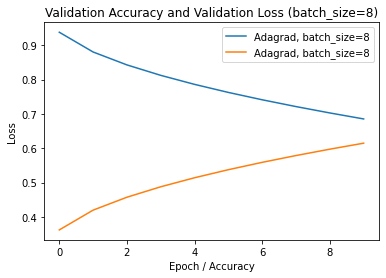

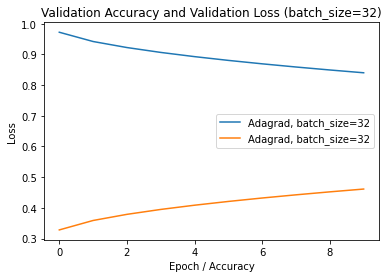

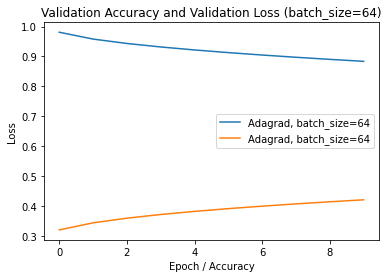

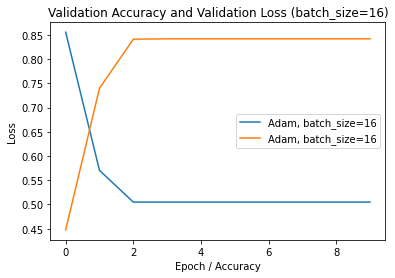

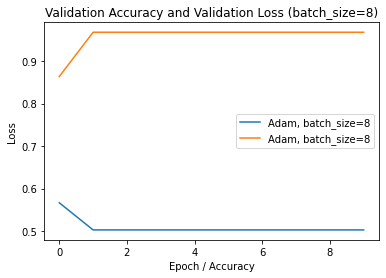

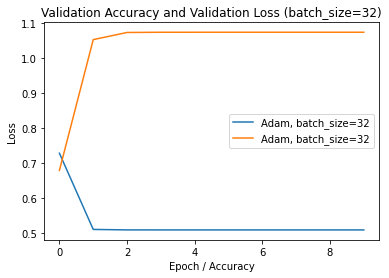

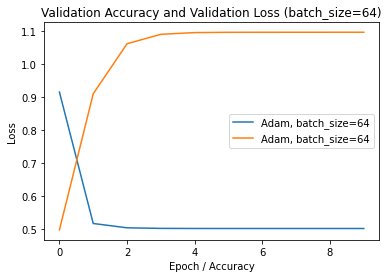

In [4]:
X_train, y_train = checkerboard(1000)
X_test, y_test = checkerboard(1000)
final_acc =[]
final_loss =[]

optim_index = 0
size_index = 0

while optim_index < len(optimizers):
    while size_index < len(batch_size):
        model = SVM(X_train, y_train, batch_size[size_index], optimizers[optim_index], 10)
        overall_loss, overall_acc = model.fit()
        plt.plot(overall_loss, label=f'{optimizers[optim_index].__class__.__name__}, batch_size={batch_size[size_index]}')
        plt.plot(overall_acc, label=f'{optimizers[optim_index].__class__.__name__}, batch_size={batch_size[size_index]}')
        plt.title(f'Validation Accuracy and Validation Loss (batch_size={batch_size[size_index]})')
        plt.xlabel('Epoch / Accuracy')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        size_index += 1
    optim_index += 1
    size_index = 0

#**Task 2**

Review one-against-one and one-against-all approaches to build a multi-class support vector classifier. A multi-class support vector classifier consists of multiple two-class support vector classifiers. Build a tensorflow input pipeline, define loss function properly, and train support vector classifiers to predict MNIST image labels. Show the confusion matrix, and plot some correctly and incorrectly classified examples.

#**Implementation**

We utilized TensorFlow input pipeline to load and preprocess the MNIST dataset. Defined a loss function appropriate for training the support vector classifiers and trained the support vector classifiers to predict MNIST image labels and evaluated the performance of the model. In this we define a MNISTClassifier class that uses SVC to classify images of handwritten digits from the MNIST dataset.
The two popular methods for creating a multi-class support vector classifier: one-against-one (OAO) and one-against-all (OAA). Both methods are used to classify multi-class problems by training binary classifiers. One-against-one (OAO): This method trains a different binary classifier for each set of classes. Each trained classifier is applied to the input data during prediction, and the class that outperforms all others in pairwise comparisons is forecasted as the final result. Although this method can be quick to train and effective with small datasets, it can be slow to predict for very big datasets.
One-against-all (OAA): In this method, one binary classifier is trained for each class. To differentiate samples from that class from samples from all other classes, each classifier is trained. Each trained classifier is applied to the input data during prediction, and the class with the highest score is selected as the predicted class. Even with big datasets, this method may be quicker to forecast than OAO, but for it to perform well, additional training data may be needed. 
The images are plotted is used to visualize some examples of the correctly and incorrectly classified images.

In [11]:
import tensorflow as tf
import numpy as np

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
train_images = np.reshape(train_images, (train_images.shape[0], -1)).astype('float32') / 255
test_images = np.reshape(test_images, (test_images.shape[0], -1)).astype('float32') / 255
train_labels = tf.keras.utils.to_categorical(train_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

In [ ]:
from sklearn import svm
from sklearn.metrics import accuracy_score

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Confusion Matrix (ovo):
 [[ 957    0    4    1    1    6    9    1    0    1]
 [   0 1122    3    2    0    1    2    1    4    0]
 [   8    6  967   11    3    3    7    8   17    2]
 [   4    3   16  947    1   16    0    9   12    2]
 [   1    1   10    1  942    2    4    2    3   16]
 [  10    4    3   36    6  803   13    1   14    2]
 [   9    2   13    1    5   16  910    1    1    0]
 [   1    8   21   10    8    1    0  957    3   19]
 [   8    4    6   25    7   26    6    7  877    8]
 [   7    7    2   11   33    4    0   18    5  922]]
Confusion Matrix (ovr):
 [[ 962    0    2    1    1    4    5    3    1    1]
 [   0 1112    3    2    0    1    5    1   11    0]
 [  11   11  914   18   10    4   13   12   36    3]
 [   4    0   19  918    2   22    5   12   19    9]
 [   1    4    5    4  913    0    9    3    5   38]
 [   9    2    0   40   12  768   17    7   29    8]
 [   7    4    7    2    5   21  909    1    2    0]
 [   2    8   23    5    7    1    1  947    4  

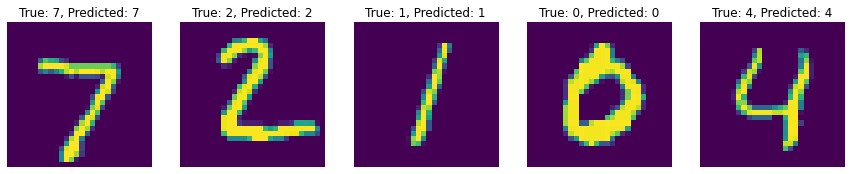

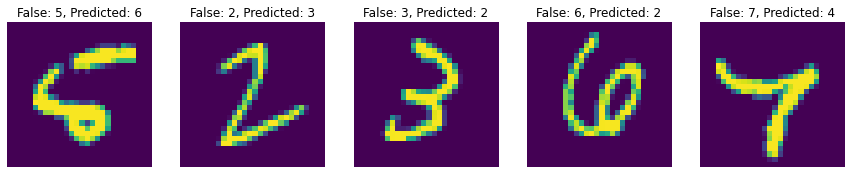

In [13]:
import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
# Define function to compute accuracy score
def accuracy_score(y_true, y_pred):
    return np.mean(y_true == y_pred)

# Define function to compute confusion matrix
def confusion_matrix(y_true, y_pred):
    K = len(np.unique(y_true)) # Number of classes 
    result = np.zeros((K, K))
    for i in range(len(y_true)):
        result[y_true[i]][y_pred[i]] += 1
    return result

# Flatten the training and testing images
train_images_flat = []
test_images_flat = []

for i in range(len(train_images)):
    train_images_flat.append(train_images[i].flatten())
train_images_flat = np.array(train_images_flat)

for i in range(len(test_images)):
    test_images_flat.append(test_images[i].flatten())
test_images_flat = np.array(test_images_flat)

# Flatten the training and testing labels
train_labels_flat = [np.argmax(label) for label in train_labels]
test_labels_flat = [np.argmax(label) for label in test_labels]

# Create an SVM classifier with ovo strategy
model = svm.SVC(kernel='linear', decision_function_shape='ovo')

# Train the SVM classifier with ovo strategy
model.fit(train_images_flat, train_labels_flat)

# Create an SVM classifier with ovr strategy
model_ovr = LinearSVC(C=1, multi_class='ovr', penalty='l2', loss='squared_hinge')

#Train the SVM classifier with ovr strategy
model_ovr.fit(train_images_flat, train_labels_flat)

# Generate predictions
predictions_ovo = model.predict(test_images_flat)
predictions_ovr = model_ovr.predict(test_images_flat)

# Compute the confusion matrix
cm_ovo = confusion_matrix(test_labels_flat, predictions_ovo)
cm_ovr = confusion_matrix(test_labels_flat, predictions_ovr)

print("Confusion Matrix (ovo):\n", cm_ovo.astype('int'))
print("Confusion Matrix (ovr):\n", cm_ovr.astype('int'))

# Compute accuracy
svm_ovo_acc = sum(predictions_ovo == test_labels_flat) / len(test_labels_flat)
svm_ovr_acc = sum(predictions_ovr == test_labels_flat) / len(test_labels_flat)

print("Accuracy of SVM with ovo strategy:", svm_ovo_acc)
print("Accuracy of SVM with ovr strategy:", svm_ovr_acc)

# Plot some correctly and incorrectly classified examples
correct_indices = []
incorrect_indices = []
for i in range(len(predictions_ovr)):
    if predictions_ovr[i] == test_labels_flat[i]:
        correct_indices.append(i)
    else:
        incorrect_indices.append(i)
correct_indices = tuple(correct_indices)
incorrect_indices = tuple(incorrect_indices)


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
for ax, idx in zip(axs, correct_indices[:5]):
    img = test_images[idx].reshape(28, 28)
    true_label = test_labels_flat[idx]
    pred_label = predictions_ovr[idx]
    ax.imshow(img)
    ax.set_title(f'True: {true_label}, Predicted: {pred_label}')
    ax.axis('off')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
for ax, idx in zip(axs, incorrect_indices[:5]):
    img = test_images[idx].reshape(28, 28)
    true_label = test_labels_flat[idx]
    pred_label = predictions_ovr[idx]
    ax.imshow(img)
    ax.set_title(f'False: {true_label}, Predicted: {pred_label}')
    ax.axis('off')
plt.show()


fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(15, 4))
for ax, idx in zip(axs, incorrect_indices[:5]):
    img = test_images[idx].reshape(28, 28)
    true_label = test_labels_flat[idx]
    pred_label = predictions_ovr[idx]
    ax.imshow(img)
    ax.set_title(f'False: {true_label}, Predicted: {pred_label}')
    ax.axis('off')
plt.show()
